<a href="https://colab.research.google.com/github/JD-man/GAN_Study/blob/main/4.DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN

- 이전 챕터와 달리 DCGAN은 GAN에 CNN 또는 ConvNet을 사용한다.
- ConvNet의 필터의 깊이는 입력의 깊이와 같고. 출력의 깊이는 필터의 개수와 같다.
- DCGAN 이전에 ConvNet과 GAN을 결합한 LAPGAN이 있었으나 불안정성과 그래디언트 포화의 문제가있었다.  
(그래디언트 포화 : 그래디언트가 너무 작아 학습이 안되는 상황)  
- DCGAN은 ConvNet과 GAN의 최적화 방법을 소개했으며 핵심기법 중 하나는 배치정규화다.


# 정규화
- 정규화는 평균이 0이고 단위 분산을 가지도록 데이터의 스케일을 조정하는 것이다.
- 정규화 값 = (데이터 값 - 평균) / 표준편차
- 각 데이터 포인트를 액면가 그대로가 아니라 평균에서 몇 표준편차만큼 떨어져 있는지 상대적인 점수로 나타내는 것
- 입력 값이 네트워크를 통과하여 다음층으로 전달될 때 각 층에 있는 파라미터들에 의해 스케일이 변한다.  
- 파라미터는 역전파에 의해 조정되기 때문에 연속적으로 훈련이 반복되는 동안 각 층의 입력의 분포가 바뀌기 쉬워 학습 과정을 불안하게 한다.  
- 이 문제를 공변량 변화 covariate shift라고하며, 배치 정규화로 해결한다.

# 배치정규화

- 신경망의 입력을 정규화하기 때문에 신경망을 통과하는 훈련 미니 배치를 위해 각 층의 입력을 정규화하는 작업
- 각 미니 배치의 평균과 분산으로 미니 배치 데이터의 스케일을 조정한다.
- 정규화 값 = (데이터 - 미니배치평균) / (미니배치분산<sup>2</sup> + 입실론)<sup>1/2</sup>
- 입실론은 0으로 나누는 것을 피하려고 입력하는 0.001과 같은 작은수이다.
- 다음 층의 입력으로 전달하기 전에 감마를 곱하고 베타를 더한다.
- 감마와 베타도 훈련되는 파라미터이다.
- 케라스의 keras.layers.BatchNormalization을 사용한다.
- 배치 정규화는 이전 층의 파라미터 업데이트가 현재 층의 입력 분포에 미치는 영향을 제한한다.
- 층 간의 원치 않는 파라미터 상호 의존성을 줄여 신경망의 훈련속도와 안정성을 높인다.
- 신경망의 파라미터 초기화에 대해 안정적이다.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

# 생성자 구현

- ConvNet은 높이X너비X컬러 차원을 가진 이미지를 입력으로 받아 클래스 점수를 담은 1Xn 차원의 벡터 하나를 출력한다. n은 클래스 레이블의 수  
- ConvNet 구조를 사용해 이미지를 생성하려면 거꾸로 벡터를 받아 크기를 늘려서 이미지로 만든다.  
- 이 과정의 핵심요소는 전치 합성곱이다.  
- 일반적인 합성곱은 깊이를 늘리면서 입력 너비와 높이를 줄인다.  
- 전치 합성곱은 반대로 깊이를 줄이는 동안 너비와 높이를 증가시킨다.

---

- 생성자는 잡음 벡터 z에서 시작해 완전연결층을 사용하여 3차원 출력으로 바꾼다.
- 전치 합성곱을 사용해 깊이는 출이고 면적을 점진적으로 늘린다.
- 전치 합성곱 층 다음에는 배치 정규화와 LeakyReLU 활성화 함수를 적용한다.
- 최종층에 도달할때 이미지 크기는 mnist 크기와 같도록 한다.
- 마지막층에서는 배치 정규화를 적용하지 않고 tanh 활성화 함수를 사용한다.
---

1. 랜덤 잡음 벡터를 받아 완전 연결 층으로 7 X 7 X 256 크기의 텐서로 변경
2. 전치 합성곱으로 7 X 7 X 256 크기를 14 X 14 X 128텐서로 변환.
3. 배치 정규화 + LeakyReLU 적용
4. 전치 합성곱으로 14 X 14 X 64 텐서로 변환. Conv2DTranspose에서 스트라이드를 1로 한다.
5. 배치 정규화 + LeakyReLU 적용
6. 전치 합성곱을 사용해 28 X 28 X 1 텐서로 변환.
7. tanh 활성화 함수 적용

In [ ]:
# 생성자 만들기 함수

def build_generator(z_dim):
  model = Sequential()

  model.add(Dense(256 * 7 * 7, input_dim=z_dim))
  model.add(Reshape((7,7,256)))
  model.add(Conv2DTranspose(128, kernel_size = 3, strides = 2, padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2DTranspose(64, kernel_size = 3, strides = 1, padding = 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2DTranspose(1, kernel_size = 3, strides = 2, padding = 'same'))
  model.add(Activation('tanh'))
  return model

# 판별자 구현

1. 합성곱 층을 사용해 28 X 28 X 1 입력 이미지를 14 X 14 X 32 크기 텐서로 변환.
2. LeakyReLU 적용
3. 합성곱 층을 사용해 14 X 14 X 32 크기 텐서를 7 X 7 X 64 크기 텐서로 변환.
4. LeakyReLU 적용
5. 합성곱 층을 사용해 3 X 3 X 128 크기 텐서로 변환.
6. LeakyReLU 적용
7. 1152 크기 벡터로 펼친다.
8. 완전 연결층과 시그모이드 활성화 함수를 사용해 입력이미지가 진짜일 확률을 계산한다.

In [ ]:
# 판별자 만들기 함수

def build_discriminator(img_shape):
  model = Sequential()
  model.add(Conv2D(32, kernel_size = 3, strides = 2, input_shape = img_shape, padding = 'same'))
  model.add(LeakyReLU(alpha = 0.01))
  model.add(Conv2D(64, kernel_size = 3, strides = 2, padding = 'same'))
  model.add(LeakyReLU(alpha = 0.01))
  model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = 'same'))
  model.add(LeakyReLU(alpha = 0.01))
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))
  return model

In [ ]:
# DCGAN 모델 생성

def build_gan(generator, discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer = Adam(), metrics=['accuracy'])

generator = build_generator(z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer = Adam())

In [ ]:
# DCGAN 훈련

losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
  (X_train,_), (_,_) = mnist.load_data()

  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    g_loss = gan.train_on_batch(z, real)

    if(iteration + 1) % sample_interval == 0:
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      print("%d [D 손실 : %f, 정확도 : %.2f%%] [G 손실 : %f]" % (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

      sample_image(generator)

In [ ]:
def sample_image(generator, image_grid_rows = 4, image_grid_columns = 4):
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  gen_imgs = generator.predict(z)
  gen_imgs = 0.5 * gen_imgs + 0.5
  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4,4),
                          sharey=True,
                          sharex=True)
  
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # gen_imgs는 (28,28,1) 크기의 이미지가 여러개있는 텐서이므로 gen_imgs[cnt,:,:,0]을 출력한다.
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray')
      axs[i, j].axis('off')
      cnt += 1
  plt.show()

11493376/11490434 [==============================] - 0s 0us/step
1000 [D 손실 : 0.401461, 정확도 : 81.64%] [G 손식 : 1.763982]


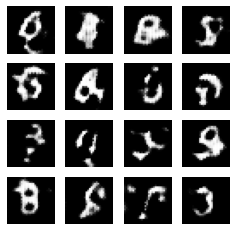

2000 [D 손실 : 0.457096, 정확도 : 76.17%] [G 손식 : 1.747293]


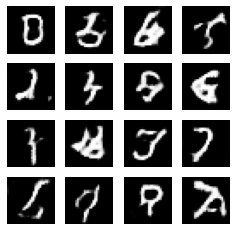

3000 [D 손실 : 0.441800, 정확도 : 79.30%] [G 손식 : 1.871163]


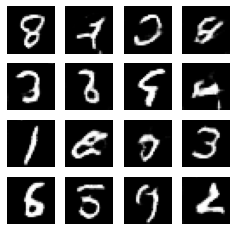

4000 [D 손실 : 0.494098, 정확도 : 75.78%] [G 손식 : 1.729006]


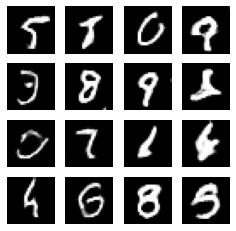

5000 [D 손실 : 0.380710, 정확도 : 84.38%] [G 손식 : 1.978347]


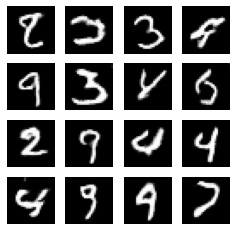

6000 [D 손실 : 0.397133, 정확도 : 81.64%] [G 손식 : 1.868162]


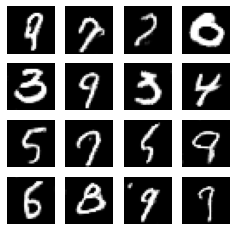

7000 [D 손실 : 0.336402, 정확도 : 86.33%] [G 손식 : 1.868739]


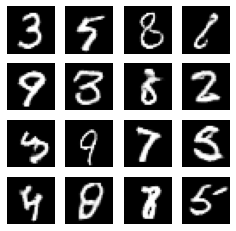

8000 [D 손실 : 0.362376, 정확도 : 85.16%] [G 손식 : 1.912971]


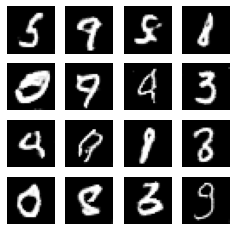

9000 [D 손실 : 0.455652, 정확도 : 79.30%] [G 손식 : 1.732445]


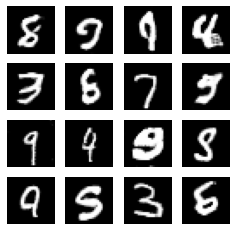

10000 [D 손실 : 0.402254, 정확도 : 81.25%] [G 손식 : 1.656392]


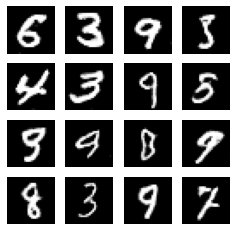

11000 [D 손실 : 0.356419, 정확도 : 83.20%] [G 손식 : 1.972205]


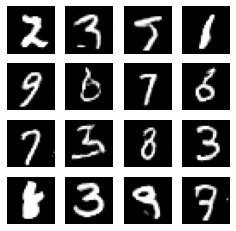

12000 [D 손실 : 0.419183, 정확도 : 80.08%] [G 손식 : 1.787126]


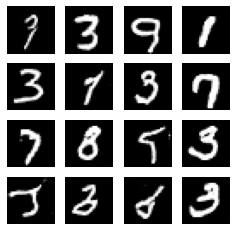

13000 [D 손실 : 0.422197, 정확도 : 79.69%] [G 손식 : 1.730496]


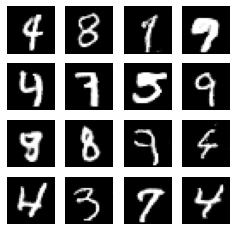

14000 [D 손실 : 0.381819, 정확도 : 80.08%] [G 손식 : 1.825025]


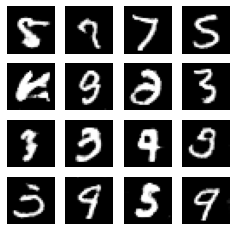

15000 [D 손실 : 0.393495, 정확도 : 81.25%] [G 손식 : 1.984741]


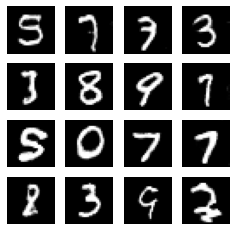

16000 [D 손실 : 0.370418, 정확도 : 84.38%] [G 손식 : 2.049415]


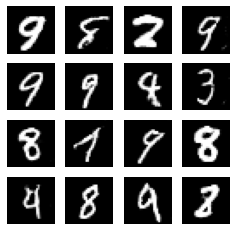

17000 [D 손실 : 0.399949, 정확도 : 82.03%] [G 손식 : 1.903799]


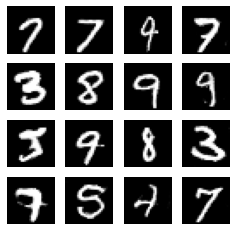

18000 [D 손실 : 0.406297, 정확도 : 82.81%] [G 손식 : 1.877938]


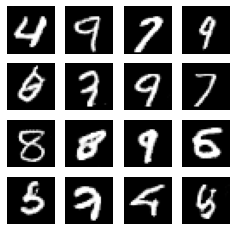

19000 [D 손실 : 0.280215, 정확도 : 87.89%] [G 손식 : 1.916079]


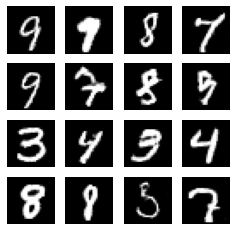

20000 [D 손실 : 0.393880, 정확도 : 82.03%] [G 손식 : 1.907087]


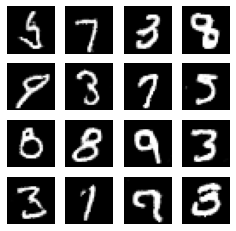

In [ ]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)